In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import timm
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
from PIL import Image

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_DATA_DIR = os.path.join('..', 'Data')
ROIS_DIR = os.path.join(ROOT_DATA_DIR, 'CLASSIFICATION_ROIS_128x128')
MODEL_SAVE_PATH = os.path.join(ROOT_DATA_DIR, 'best_efficientnet_b4.pth')
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

In [3]:
class PCBDefectDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        self.label_map = {label: i for i, label in enumerate(sorted(list(set(labels))))}
        self.num_classes = len(self.label_map)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        label_str = self.labels[idx]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
def load_data_paths():
    all_files = glob.glob(os.path.join(ROIS_DIR, '*', '*.png'))
    all_labels = [os.path.basename(os.path.dirname(f)) for f in all_files]
    return all_files, all_labels

def get_transforms(is_train):
    if is_train:
        return transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects.double() / total_train
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                total_val += labels.size(0)

        val_epoch_loss = val_loss / total_val
        val_epoch_acc = val_corrects.double() / total_val
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("Model saved!")
            
    return history, best_acc.item()

In [6]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Starting training on 2445 samples for 6 classes...
Epoch 1/10 - Train Loss: 1.7677, Train Acc: 0.4254, Val Loss: 0.9900, Val Acc: 0.6209
Model saved!
Epoch 2/10 - Train Loss: 0.7264, Train Acc: 0.7260, Val Loss: 0.5348, Val Acc: 0.8039
Model saved!
Epoch 3/10 - Train Loss: 0.4482, Train Acc: 0.8372, Val Loss: 0.3507, Val Acc: 0.8791
Model saved!
Epoch 4/10 - Train Loss: 0.3115, Train Acc: 0.8883, Val Loss: 0.2029, Val Acc: 0.9281
Model saved!
Epoch 5/10 - Train Loss: 0.2294, Train Acc: 0.9170, Val Loss: 0.1872, Val Acc: 0.9346
Model saved!
Epoch 6/10 - Train Loss: 0.1602, Train Acc: 0.9448, Val Loss: 0.1463, Val Acc: 0.9314
Epoch 7/10 - Train Loss: 0.1577, Train Acc: 0.9440, Val Loss: 0.1317, Val Acc: 0.9510
Model saved!
Epoch 8/10 - Train Loss: 0.1407, Train Acc: 0.9501, Val Loss: 0.1094, Val Acc: 0.9526
Model saved!
Epoch 9/10 - Train Loss: 0.1047, Train Acc: 0.9624, Val Loss: 0.1052, Val Acc: 0.9592
Model saved!
Epoch 10/10 - Train Loss: 0.0832, Train Acc: 0.9677, Val Loss: 0.0975, 

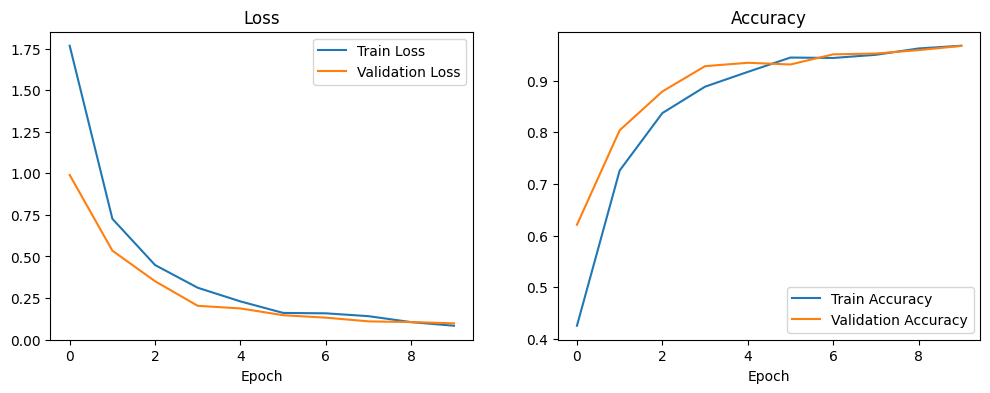

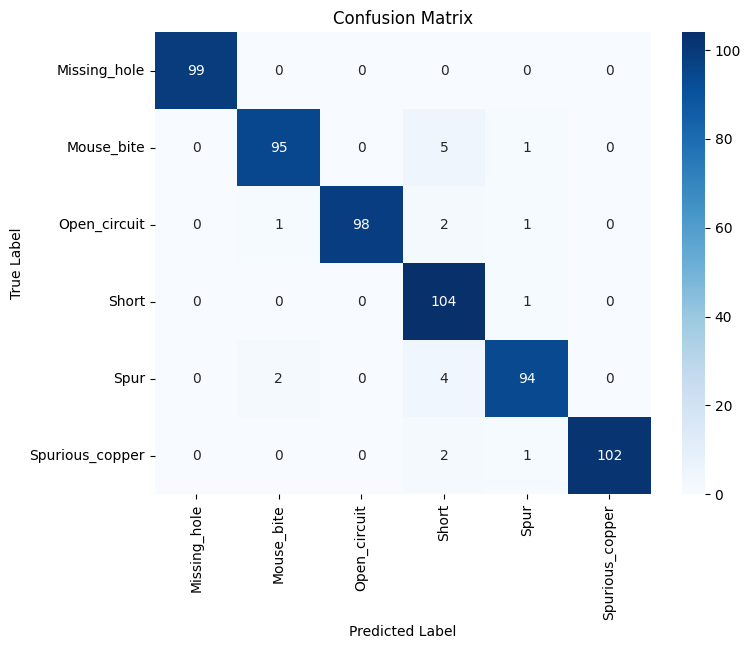

In [7]:
files, labels = load_data_paths()
if not files:
    print(f"Error: No files found in {ROIS_DIR}. Check your M2 output.")
else:
    train_files, val_files, train_labels, val_labels = train_test_split(
        files, labels, test_size=0.2, stratify=labels, random_state=42
    )

    train_dataset = PCBDefectDataset(train_files, train_labels, transform=get_transforms(is_train=True))
    val_dataset = PCBDefectDataset(val_files, val_labels, transform=get_transforms(is_train=False))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    num_classes = train_dataset.num_classes
    class_names = list(train_dataset.label_map.keys())

    model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=num_classes)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"Starting training on {len(train_dataset)} samples for {num_classes} classes...")
    history, best_val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS)

    print(f"\nTraining finished. Best validation accuracy: {best_val_acc:.4f}")

    plot_history(history)
    
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    true_labels, predicted_labels = evaluate_model(model, val_loader)
    
    reverse_map = {v: k for k, v in train_dataset.label_map.items()}
    true_class_names = [reverse_map[label] for label in true_labels]
    pred_class_names = [reverse_map[label] for label in predicted_labels]

    plot_confusion_matrix(true_class_names, pred_class_names, class_names)